In [1]:
import numpy as np
import pickle as pkl

from scipy import optimize
from scipy.linalg import cho_factor, cho_solve
import matplotlib.pyplot as plt
from utils import plotClassification, plotRegression, plot_multiple_images, generateRings, scatter_label_points, loadMNIST

In [2]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from skimage.feature import hog
from skimage import exposure
from skimage.transform import resize

from sklearn.model_selection import train_test_split

# Load the data

In [3]:
import pandas as pd

In [4]:
X_train = pd.read_csv('dataset/Xtr.csv', header = None, sep=',', usecols = range(3072))
X_test = pd.read_csv('dataset/Xte.csv', header = None, sep=',', usecols = range(3072))
Y_train = pd.read_csv('dataset/Ytr.csv')

In [5]:
X_train.shape

(5000, 3072)

# Split the data

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.25)

In [7]:
X_train.shape

(3750, 3072)

In [8]:
y_train

,Id,Prediction
3924,3925,3
76,77,4
2431,2432,6
134,135,1
2626,2627,3
...,...,...
4975,4976,7
1761,1762,1
1873,1874,7
486,487,8


In [9]:
#X_train = (X_train - X_train.mean())/X_train.std()

In [10]:
#X_val = (X_val - X_train.mean())/X_train.std()

# Visualize the data

In [11]:
def reconstructImage(data):

    rows = data.values
    
    nb, N = rows.shape
    red_channel = rows[:,:N//3]
    min_red = red_channel.min(1).reshape(-1,1)
    max_red = red_channel.max(1).reshape(-1,1)
    red_channel = (red_channel-min_red)/(max_red-min_red)

    green_channel = rows[:,N//3:2*N//3]
    min_green = green_channel.min(1).reshape(-1,1)
    max_green = green_channel.max(1).reshape(-1,1)
    green_channel = (green_channel-min_green)/(max_green-min_green)

    blue_channel = rows[:,2*N//3:]
    min_blue = blue_channel.min(1).reshape(-1,1)
    max_blue = blue_channel.max(1).reshape(-1,1)
    blue_channel = (blue_channel-min_blue)/(max_blue-min_blue)

    newdata = np.hstack((red_channel,green_channel,blue_channel))
    newdata = newdata.reshape(nb,3,32,32).transpose(0,2,3,1)
    return newdata

def plot_image(data, index):

    row = data.iloc[index].values
    N = row.shape[0]
    red_channel = row[:N//3].reshape(-1,1)
    min_value = red_channel.min()
    max_value = red_channel.max()
    red_channel = np.array(1*(red_channel - min_value)/(max_value-min_value))
    
    green_channel = row[N//3:2*N//3].reshape(-1,1)
    min_value = green_channel.min()
    max_value = green_channel.max()

    
    green_channel = np.array(1*(green_channel - min_value)/(max_value-min_value))


    blue_channel = row[2*N//3:].reshape(-1,1)
    min_value = blue_channel.min()
    max_value = blue_channel.max()
    blue_channel = np.array(1*(blue_channel - min_value)/(max_value-min_value))
    

    image = np.hstack((red_channel,green_channel,blue_channel))
    image = image.reshape(32,32,3)
    plt.figure(figsize=(8,8))
    plt.imshow(image)
    
def create_Submissioncsv(y_test):

    f = open("result/submission.csv", "w")
    f.write("Id,Prediction\n")
    for n in range(len(y_test)):
        f.write("{},{}\n".format(int(n+1),y_test[n]))
    f.close()

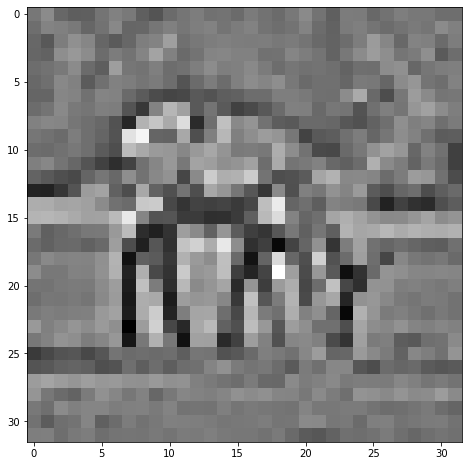

In [12]:
newdata = reconstructImage(X_train)
plt.figure(figsize=(8,8))
plt.imshow(newdata[1])
plt.show()

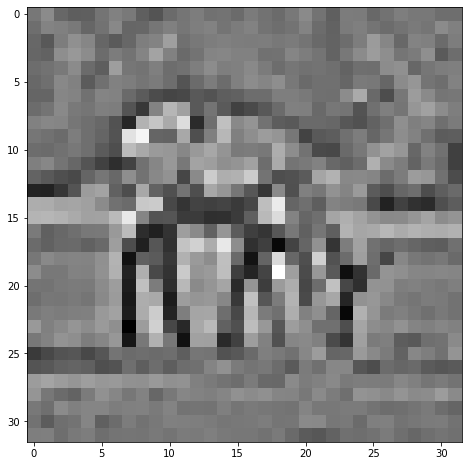

In [13]:
plot_image(X_train,1)

In [14]:
newdata_test = reconstructImage(X_val)

# Kernel

In [15]:
class RBF:
    def __init__(self, sigma=1.):
        self.sigma = sigma  ## the variance of the kernel
    def kernel(self,X,Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        N, d = X.shape 
        M, _ = Y.shape
        X = X.reshape(N,1,d,1)
        Y = Y.reshape(1,M,d,1)
        G = ((X-Y).transpose((0, 1, 3, 2))@(X-Y)).reshape(N,M)
        return np.exp(-G/(2*self.sigma**2))
    
class Linear:
    def __init__(self): 
        self = self
    def kernel(self,X,Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        return X @ Y.T

In [16]:
class KernelSVC:
    
    def __init__(self, C, kernel, epsilon = 1e-3):
        self.type = 'non-linear'
        self.C = C                               
        self.kernel = kernel        
        self.alpha = None
        self.support = None
        self.epsilon = epsilon
        self.norm_f = None
        self.diag = None
        self.label1 = None
        self.label2 = None
    
    def fit(self, X, y):
       #### You might define here any variable needed for the rest of the code
        N = len(y)
        K = self.kernel(X,X)
        y_diag = np.diag(y)
        self.label1 = np.unique(y)[0] 
        self.label2 = np.unique(y)[1]
        
        # Lagrange dual problem
        def loss(alpha):
            #'''--------------dual loss ------------------ '''
            return - alpha.sum() + 0.5 * alpha.T @ y_diag @ K @ y_diag @ alpha

        # Partial derivate of Ld on alpha
        def grad_loss(alpha):
            # '''----------------partial derivative of the dual loss wrt alpha-----------------'''
            return - np.ones(N) + y_diag @ K @ y_diag @ alpha


        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0

        fun_eq = lambda alpha: (0 - y.T @ alpha).reshape(1,1) # '''----------------function defining the equality constraint------------------'''        
        jac_eq = lambda alpha:  - y #'''----------------jacobian wrt alpha of the  equality constraint------------------'''
    
        fun_ineq = lambda alpha:  self.C*np.vstack((np.ones((N,1)),np.zeros((N,1)))) - (np.vstack((np.eye(N),-np.eye(N)))@alpha).reshape(2*N,1) # '''---------------function defining the ineequality constraint-------------------'''     
        jac_ineq = lambda alpha:   - np.vstack((np.eye(N),-np.eye(N))) # '''---------------jacobian wrt alpha of the  inequality constraint-------------------'''
            
        constraints = ({'type': 'eq',  'fun': fun_eq, 'jac': jac_eq},
                       {'type': 'ineq', 
                        'fun': fun_ineq , 
                        'jac': jac_ineq})
        
        optRes = optimize.minimize(fun=lambda alpha: loss(alpha),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda alpha: grad_loss(alpha), 
                                   constraints=constraints)

        self.alpha = optRes.x 
        ## Assign the required attributes
        
        # Support vectors on the margin
        supportIndices = np.logical_and(self.alpha>self.epsilon, self.alpha<self.C-self.epsilon)
        self.support = X[supportIndices] #'''------------------- A matrix with each row corresponding to a support vector ------------------'''
        
        self.b = (y - y_diag @ self.alpha @ K)[supportIndices].mean() #''' -----------------offset of the classifier------------------ '''
        self.norm_f = np.sqrt(self.alpha.T @ y_diag @ K @ y_diag @ self.alpha) # '''------------------------RKHS norm of the function f ------------------------------'''
        
        # Support vectors & intermediate variable 
        # for computing the separating function
        self.X_sp = X[np.where(self.alpha>self.epsilon)]
        self.diag = np.diag(y[np.where(self.alpha>self.epsilon)])@ self.alpha[np.where(self.alpha>self.epsilon)]

    ### Implementation of the separating function $f$
    def separating_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        return self.diag.T @ self.kernel(self.X_sp,x)
    
    
    def predict(self, X):
        """ Predict y values in {label1, label2} """
        d = self.separating_function(X)
        print(d)
        if str(self.b)=='nan': b = 0
        return (self.label1 - self.label2) * (d+self.b > 0) + self.label2

In [17]:
########### ONE TO ONE #############

class MultClassSVMClassifier(object):
    
    def __init__(self, C, kernel):
        self.C = C
        self.kernel = kernel
        self.classifiers = []
    
    def fit(self, X_train, y_train):
        # Récupération du nombre de classes
        k = np.unique(y_train).size
        labels = np.unique(y_train)
        # Création des k(k-1)/2 classifieurs
        for i in range(k):
            for j in range(i+1, k):
                svm = KernelSVC(C = self.C, kernel = self.kernel)
                indexes = np.logical_or(y_train == labels[i],y_train == labels[j])
                svm.fit(X_train[indexes], y_train[indexes])
                self.classifiers.append(svm)
                
    def predict(self, X_test):
        predicts = []
        for classifier in self.classifiers:
            predicts.append(classifier.predict(X_test))
            
        predicts = np.transpose(predicts)
        # Vote à majorité 
        result = [np.bincount(x).argmax() for x in predicts]
        return result

# TEST

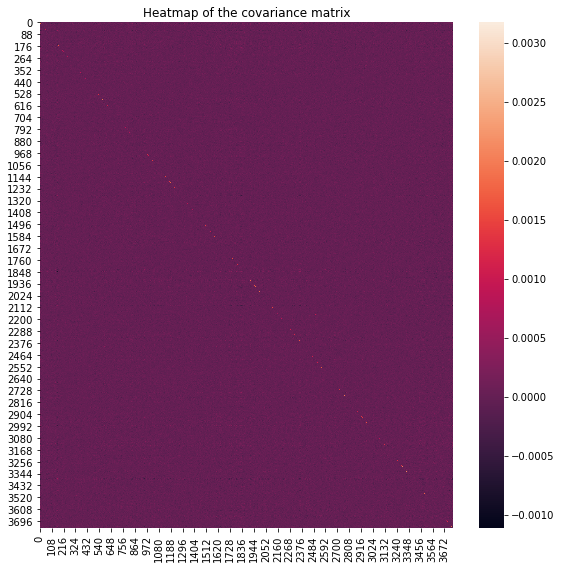

In [18]:
import seaborn as sns
plt.figure(figsize=(8,8))

#Plot of the heatmap matrix
M =np.cov(X_train)
hm = sns.heatmap(M)
plt.title('Heatmap of the covariance matrix')
plt.tight_layout()
plt.show()

#Computation of the singular value decomposition 
U, s, V = np.linalg.svd(M)

X_train = (U * s)[:, :10]

In [19]:
M_val =np.cov(X_val)
U, s, V = np.linalg.svd(M_val)
X_val = (U * s)[:, :10]

In [20]:
#clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf = SVC(C = 100, gamma = 100)
clf.fit(X_train, y_train.Prediction)

test = clf.predict(X_val)

In [21]:
test

array([0, 5, 0, ..., 0, 0, 0])

In [22]:
clf.score(X_val, y_val.Prediction)

0.0912

In [23]:
y_val.Prediction

4569    6
2450    1
2587    1
4252    6
4007    8
       ..
502     9
4013    2
1617    4
2447    8
4910    5
Name: Prediction, Length: 1250, dtype: int64

In [24]:
sigma = 100
C=100.
kernel = RBF(sigma).kernel
model = MultClassSVMClassifier(C=C, kernel=kernel)

model.fit(X_train, y_train.Prediction.values)
#plotClassification(X_train, Ytr, model, label='Training', ax=ax[2])
#Y_test = model.predict(X_test)

<ipython-input-16-9a912b58fa5f>:62: RuntimeWarning: Mean of empty slice.
  self.b = (y - y_diag @ self.alpha @ K)[supportIndices].mean() #''' -----------------offset of the classifier------------------ '''
/Users/macrafa/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [25]:
Y_test = model.predict(X_val)

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

In [26]:
np.where(np.array(Y_test)<9)

(array([], dtype=int64),)

# Hog feature

a
 remplir

# Test avec sklearn 

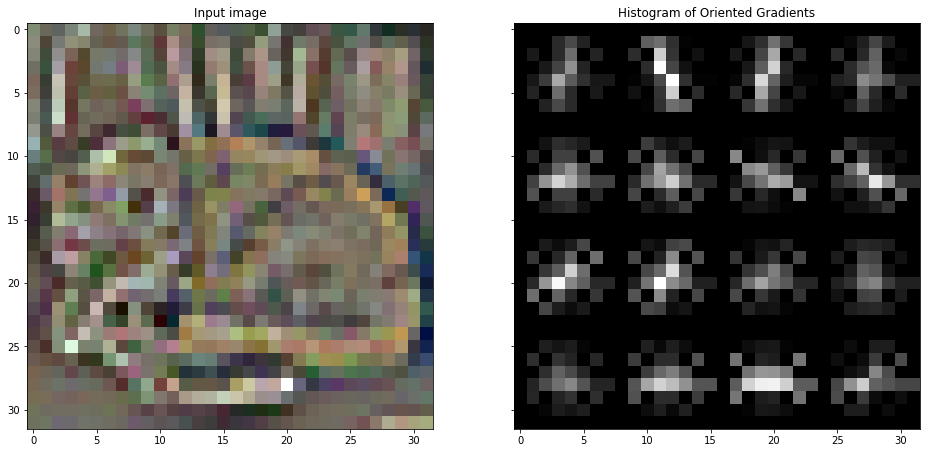

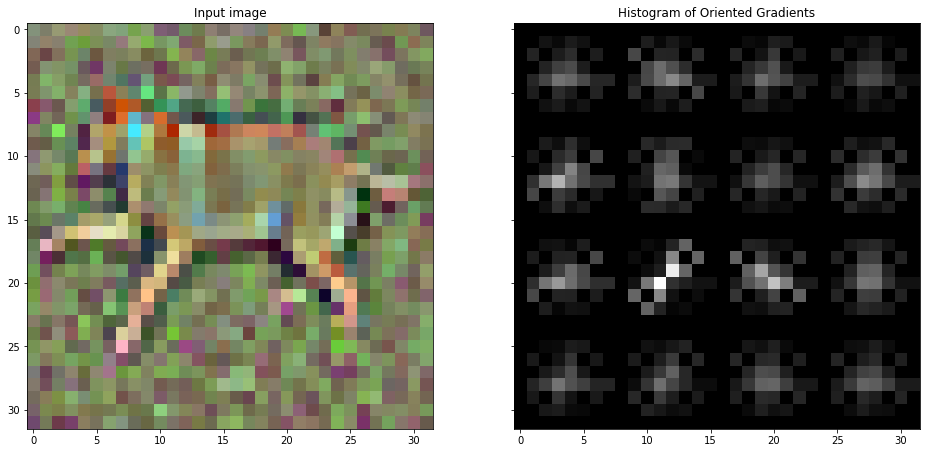

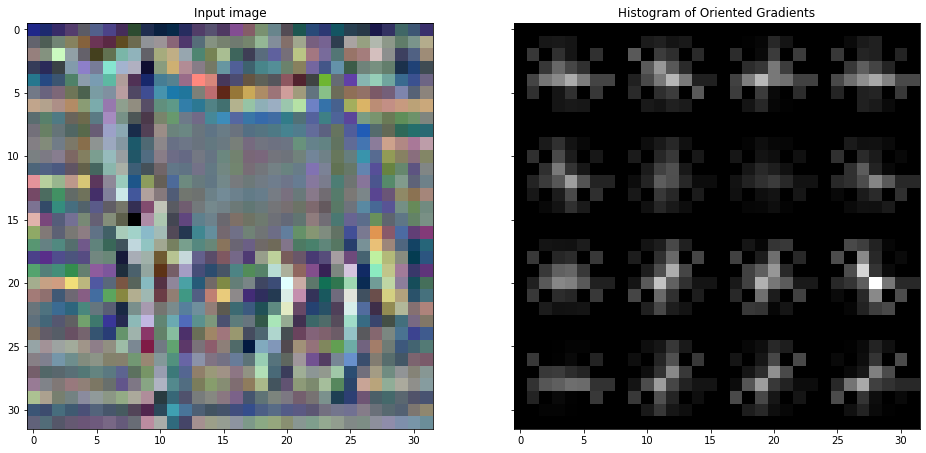

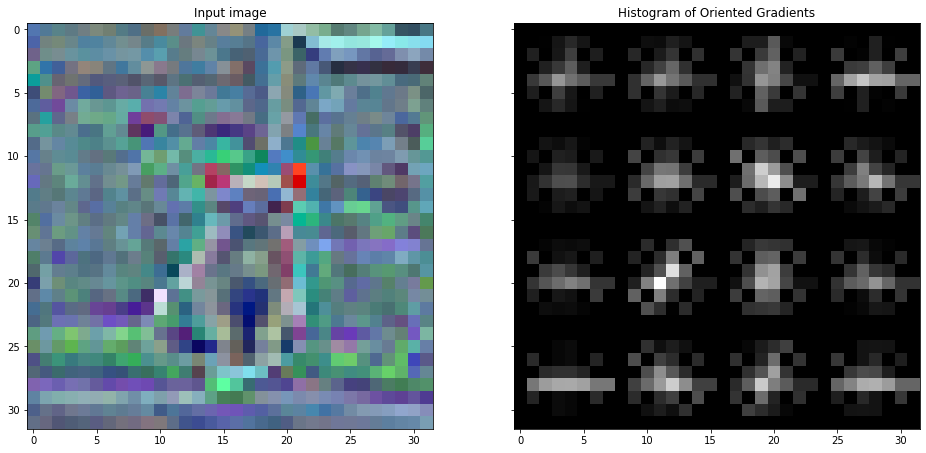

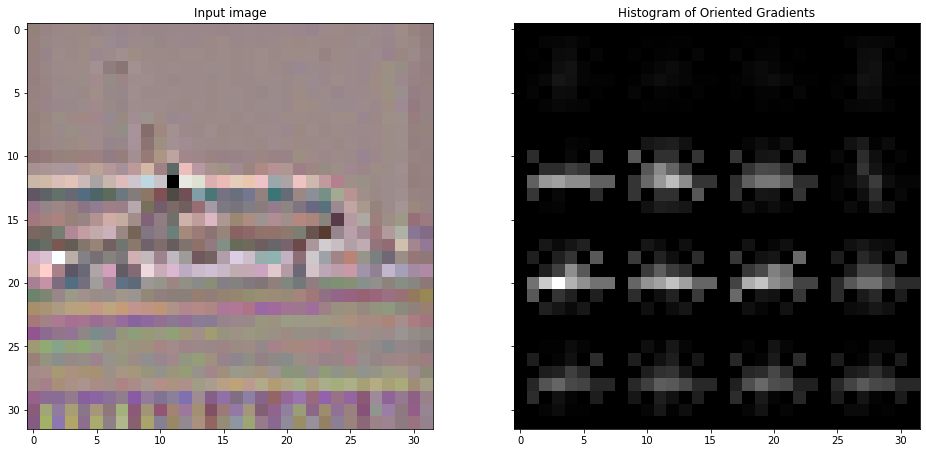

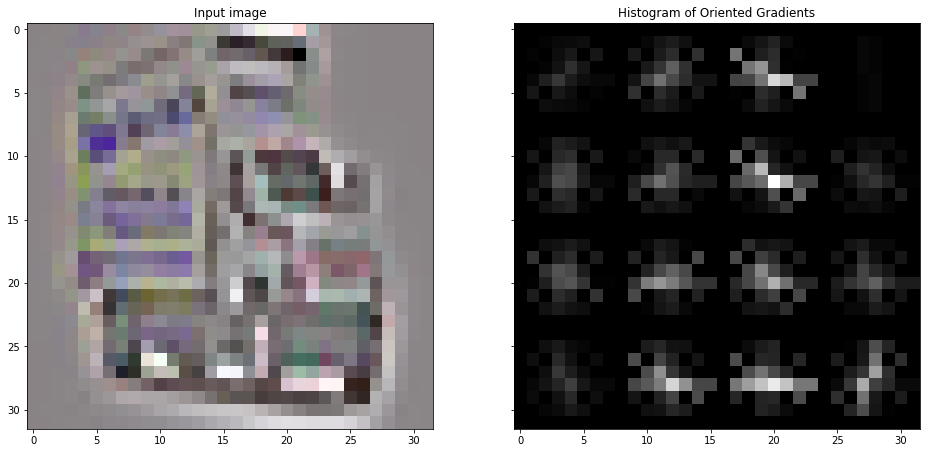

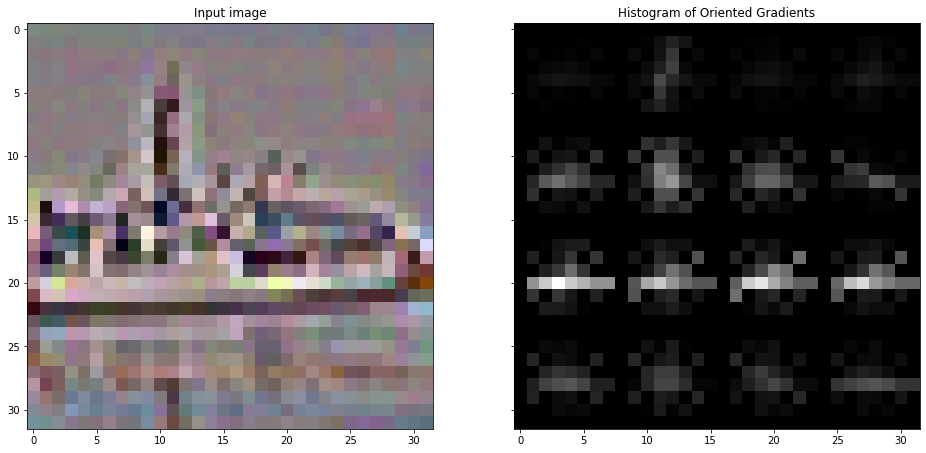

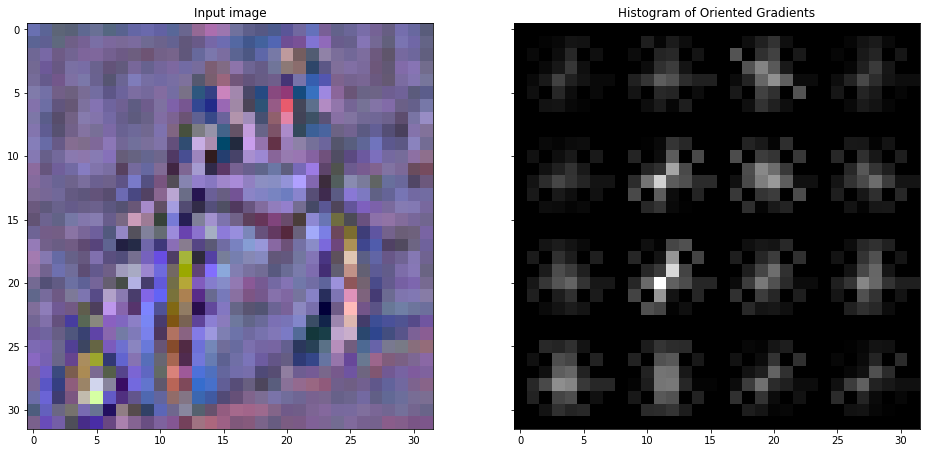

In [27]:
hog_data = np.zeros((X_train.shape[0],144))
for i in range (len(newdata)):
    #resized_img = resize(newdata[i], (128*4, 64*4))
    resized_img = newdata[i]

    fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(1, 1), visualize=True, multichannel=True)


    
    # Rescale histogram for better display 
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10)) 

    hog_data[i] = fd
    
    if i%500 == 0 : 

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True) 

        ax1.imshow(resized_img, cmap=plt.cm.gray) 
        ax1.set_title('Input image') 

        ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray) 
        ax2.set_title('Histogram of Oriented Gradients')

        plt.show()

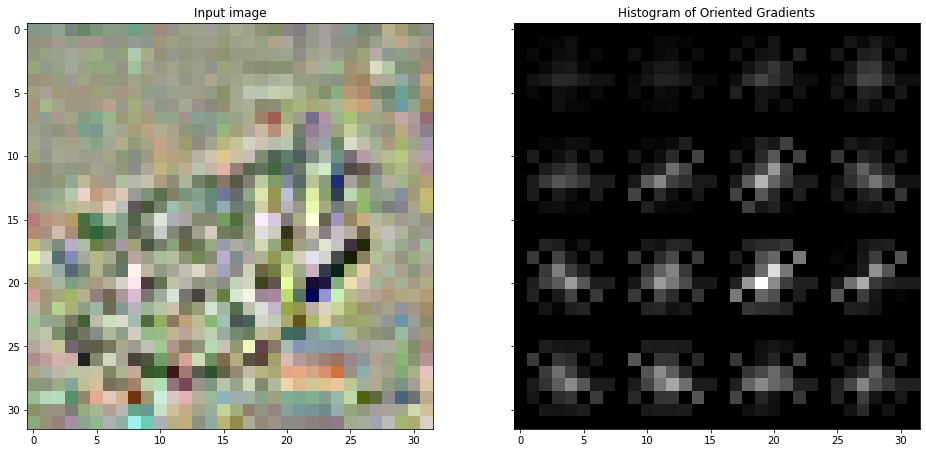

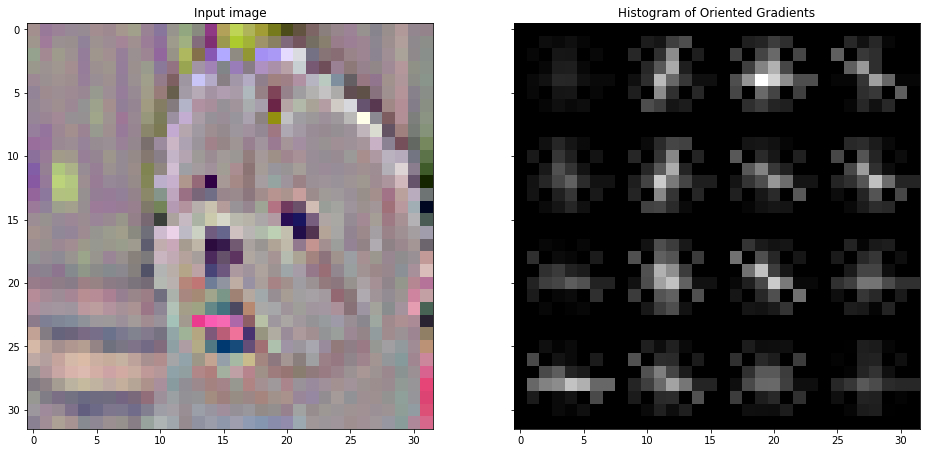

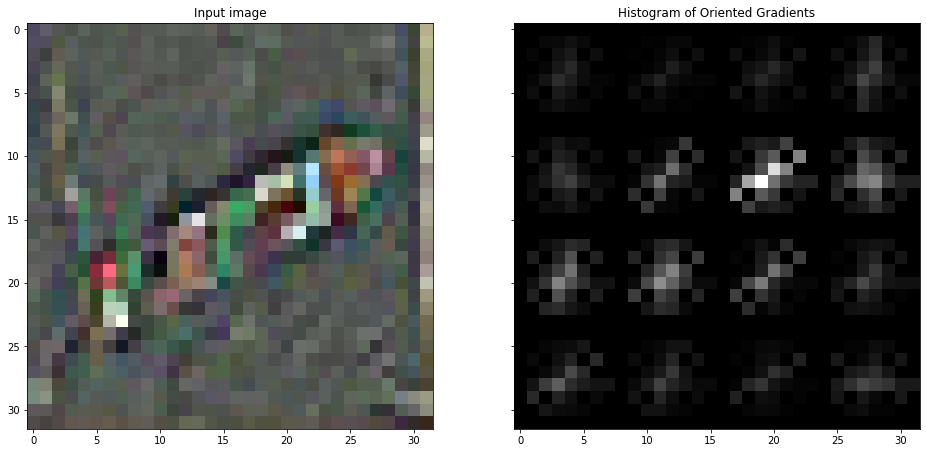

In [29]:
hog_data_test = np.zeros((X_val.shape[0],144))

for i in range (len(newdata_test)):
    #resized_img = resize(newdata_test[i], (128*4, 64*4))
    resized_img = newdata_test[i]

    fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(1, 1), visualize=True, multichannel=True)



    # Rescale histogram for better display 
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10)) 

    hog_data_test[i] = fd
    
    if i%500 == 0 : 

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True) 

        ax1.imshow(resized_img, cmap=plt.cm.gray) 
        ax1.set_title('Input image') 

        ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray) 
        ax2.set_title('Histogram of Oriented Gradients')

        plt.show()

In [ ]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf = SVC(gamma='auto', C = 10)
clf.fit(hog_data, y_train["Prediction"].values)

clf.predict(hog_data_test)

In [ ]:
clf.score(hog_data_test,y_val["Prediction"].values)

In [ ]:
y_val.shape